Thanks to the authors of theses tutorials:
- https://www.youtube.com/watch?v=a4Yfz2FxXiY
- https://learnopencv.com/denoising-diffusion-probabilistic-models/
- https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=KOYPSxPf_LL7
Some of the code is taken from the tutorials above. I tried to do as much as possible by myself.


In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
from torch import nn
import numpy as np
import torch


## Data Preprocessing

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
batch_size = 64
dataset = MNIST(root='', train=True, download=True, transform=preprocess)
loader_train = DataLoader(dataset, batch_size, shuffle=True)
print(dataset[0])

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -

## Model

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 1, 28, 28])


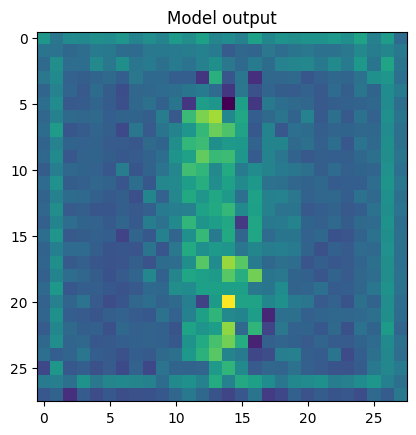

In [4]:
class SinusoidalPositionEmbeddings(nn.Module):
    '''Sinusoidal position embeddings for time parameter used to encode timestep of the forward diffusion process.'''
    def __init__(self, dim, device='cpu'):
        super().__init__()
        self.dim = dim
        self.device = device

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=self.device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ConvBlock(nn.Module):
    '''Convolutional block for U-Net encoder and decoder'''
    def __init__(self, in_channels, out_channels, time_embed_dim=32):
        super().__init__()
        self.time_mlp = nn.Linear(time_embed_dim, out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels,out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x, t):
        x = self.conv1(x)
        time_emb = self.relu(self.time_mlp(t))
        x = x + time_emb[(..., ) + (None, ) * 2]
        x = self.conv2(x)
        return x
    
class DownBlock(nn.Module):
    '''Down sampling ResNet block'''
    def __init__(self, in_channels,out_channels):
        super().__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x, t):
        skip_connection = self.conv_block(x, t)
        x = self.maxpool(skip_connection)
        return x, skip_connection
    
    
class UpBlock(nn.Module):
    '''Up sampling ResNet block'''
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, in_channels, 2, stride=2)
        self.conv_block = ConvBlock(2*in_channels, out_channels)
    def forward(self, x, skip_conn, t):
        x = self.deconv(x)
        x = torch.cat([x, skip_conn], dim=1)
        return self.conv_block(x, t)
    
    
class UNet(nn.Module):
    '''UNet based on ResNet architecture for Diffusion.'''
    def __init__(self, in_channels=1, out_channels=1, block_out_channels=[128, 256, 512], time_embed_dim=32, device='cpu'):
        '''Initialize a UNet model.
        in_channels: channels of input images.
        out_channels: channels of output images.
        block_out_channels: number of channels as output of each UNet convolotional block.'''
        super().__init__()
        assert len(block_out_channels)>=1
        # Intitialize encoder list and decoder list
        self.encoder = nn.ModuleList()
        self.encoder.append(DownBlock(in_channels, block_out_channels[0]))
        self.decoder = nn.ModuleList()
        self.decoder.append(UpBlock(block_out_channels[0], block_out_channels[0]))
        self.neck = ConvBlock(block_out_channels[-1], block_out_channels[-1])
        for i in range(len(block_out_channels)-1):
            self.encoder.append(DownBlock(block_out_channels[i], block_out_channels[i + 1]))
            self.decoder.insert(0, UpBlock(block_out_channels[i+1],block_out_channels[i]))
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_embed_dim, device=device),
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.ReLU(),
        )
        self.outConv = nn.Sequential(nn.Conv2d(block_out_channels[0], out_channels, 1), nn.Sigmoid(), nn.Conv2d(out_channels, out_channels, 1))
    
    def forward(self, x, timestep):
        skip_connections = []
        timestep_tensor = torch.ones(1).to(x.device) * timestep
        t = self.time_mlp(timestep_tensor)
        for down_block in self.encoder:
            x, w = down_block(x, t)
            skip_connections.append(w)
        x = self.neck(x, t)
        for w, up_block in zip(skip_connections[::-1], self.decoder):
            x = up_block(x, w, t)
        x = self.outConv(x)
        return x
    
    def to(self, device):
        super().to(device)
        self.time_mlp.to(device)
        return self

model = UNet(in_channels=1, out_channels=1, block_out_channels=[32, 64],)

sample_image = dataset[8][0].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, torch.ones(1)).shape)
plt.imshow(model(sample_image, torch.ones(1)).squeeze().detach().numpy())
plt.title("Model output")
plt.show()

## Forward diffusion scheduler

The scheduler generates samples from the forward diffusion process in a non-itertive way. It's a method used to speed up the process of generating noisy images.

torch.Size([5, 1, 28, 28])
torch.Size([5, 1, 28, 28])


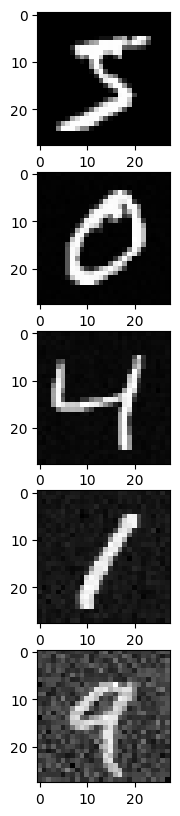

In [5]:
class DDPM():
    '''Scheduler for performing forward and reverse diffusion.'''
    def __init__(self, shape, device='cpu', steps=1000,) -> None:
        '''Initialize a DDPM model.
        shape: shape of input images.
        steps: number of noising and denoising steps'''
        self.shape = shape
        self.device = device
        self.steps = steps
        self.beta = self.get_betas()
        self.alpha = 1 - self.beta
        self.alpha_cumulative = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative = torch.sqrt(self.alpha_cumulative)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)
        
    @torch.no_grad()
    def get_betas(self):
        '''Choose betas as proposed in the original DDPM paper. Linear schedule for betas between B_1 = 10e-4 and B_T = 0.02'''
        return torch.linspace(10e-4, 0.02, self.steps).to(self.device)
    
    @torch.no_grad()
    def forward_diffusion(self, x0:torch.Tensor, timesteps):
        '''Performs forward diffusion on batch of images x0 for timesteps'''
        x0 = x0.permute(1, 2, 3, 0)
        epsilon = torch.randn(x0.shape).to(self.device)
        mean = x0 * self.sqrt_alpha_cumulative[timesteps]
        std_dev = 1 * self.sqrt_one_minus_alpha_cumulative[timesteps]
        sample = mean + std_dev * epsilon
        sample = sample.permute(3, 0, 1, 2)
        epsilon = epsilon.permute(3, 0, 1, 2)
        return sample, epsilon
    
scheduler = DDPM(shape=sample_image.shape, device='cpu', steps=1000)
    
timestep = 45
scheduler.forward_diffusion(sample_image, timestep)
#plt.imshow(sample_image.squeeze().detach().numpy(), cmap='gray')
#plt.show()
n = 5
fig, axes = plt.subplots(n, figsize=(15, 10))
samples = loader_train.dataset.data[:n].unsqueeze(1).float()
print(samples.shape)
timesteps = [i * 200 for i in range(n)]

sample, _ = scheduler.forward_diffusion(samples, timesteps)
print(sample.shape)
for i, (ax, t) in enumerate(zip(axes.flatten(), timesteps)):
    ax.imshow(sample[i].squeeze().detach().numpy(), cmap='gray')
plt.show()


The loss is simply the MSE or L1 loss between the sampled noise in the image (forward diffusion output) and the model prediction from the noisy image given by the forward diffusion.

## Training loop

The model is trained on one step of the forward diffusion at a time.

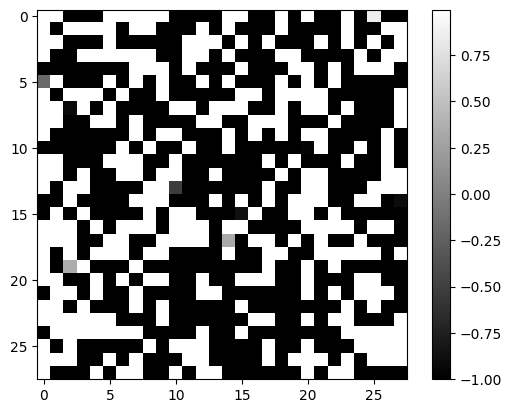

In [13]:
from tqdm import tqdm
import torch.nn.functional as F

@torch.no_grad()
def backward_diffusion(model, x, timesteps, scheduler):
    '''Performs backward diffusion on batch of images x for timesteps'''
    x_pred = x
    for t in reversed(range(timesteps)):
        x_noise_pred = model(x_pred, t)
        x_noise_pred = x_noise_pred*2 - 1
        if t == 0:
            x_pred = x_pred - (scheduler.beta[t]/scheduler.sqrt_one_minus_alpha_cumulative[t]) * x_noise_pred
        else:
            x_pred = (x_pred - (scheduler.beta[t]/scheduler.sqrt_one_minus_alpha_cumulative[t]) * x_noise_pred)/torch.sqrt(scheduler.alpha[t]) + scheduler.sqrt_one_minus_alpha_cumulative[t]*torch.randn(x_pred.shape).to(x_pred.device)
        x_pred = torch.clamp(x_pred, -1, 1)
    return x_pred


def train(model, dataloader, loss_fn, optimizer, scheduler, device='cpu', epochs=100, print_every=1):
    '''Training loop'''
    model.to(device)
    model.train()
    for epoch in range(epochs):
        for i, (x, _) in tqdm(enumerate(dataloader)):
            x = x.to(device)
            optimizer.zero_grad()
            timesteps = torch.randint(0, scheduler.steps, (x.shape[0],)).to(device)
            x_noised, noise = scheduler.forward_diffusion(x, timesteps)
            
            noise_pred = model(x_noised, timesteps)
            loss = loss_fn(noise, noise_pred * 2 - 1)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        if epoch % print_every == 0:
            noise = torch.randn(1, 1, 28, 28).to(device)
            pred = backward_diffusion(model, noise, 1000, scheduler)
            fig, axes = plt.subplots(1, 2, figsize=(15, 10))
            axes[0].imshow(noise.squeeze().detach().cpu().numpy(), cmap='gray')
            axes[0].set_title("Noised image")
            axes[1].imshow(pred[0].squeeze().detach().cpu().numpy(), cmap='gray')
            axes[1].set_title("Reconstructed image")
            plt.show()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(in_channels=1, out_channels=1, block_out_channels=[32,64],device=device)

loss_fn = nn.L1Loss()
learning_rate = 1e-3
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = DDPM(shape=sample_image.shape, device=device, steps=1000)
model = model.to(device)

sample_image = sample_image.to(device)
img = backward_diffusion(model, torch.randn(1, 1, 28, 28).to(device), 1000, scheduler)
plt.imshow(img.squeeze().detach().cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()
model = train(model, loader_train, loss_fn, optimizer, scheduler, device=device, epochs=epochs, print_every=5)



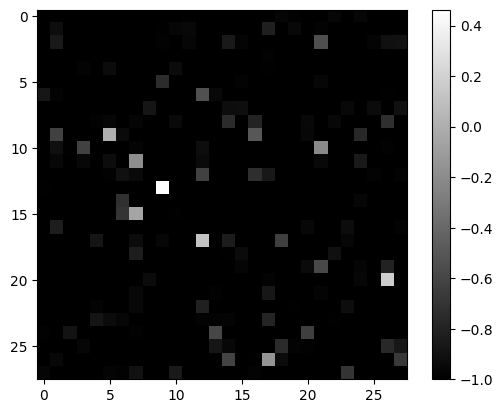

tensor([0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9994, 0.9994, 0.9994,
        0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9994, 0.9993, 0.9993,
        0.9993, 0.9993, 0.9993, 0.9993, 0.9993, 0.9993, 0.9993, 0.9993, 0.9993,
        0.9992, 0.9992, 0.9992, 0.9992, 0.9992, 0.9992, 0.9992, 0.9992, 0.9992,
        0.9992, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9991, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9990, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989,
        0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9988, 0.9988, 0.9988,
        0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9987, 0.9987,
        0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987,
        0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986,
        0.9986, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
        0.9985, 0.9985, 0.9985, 0.9984, 

In [14]:
import torch.nn.functional as F
@torch.no_grad()
def backward_diffusion(model, x, timesteps, scheduler):
    '''Performs backward diffusion on batch of images x for timesteps'''
    x_pred = x
    for t in reversed(range(timesteps)):
        x_noise_pred = model(x_pred, t)
        if t == 0:
            x_pred = x_pred - (scheduler.beta[t]/scheduler.sqrt_one_minus_alpha_cumulative[t]) * x_noise_pred
        else:
            x_pred = (x_pred - (scheduler.beta[t]/scheduler.sqrt_one_minus_alpha_cumulative[t]) * x_noise_pred)/torch.sqrt(scheduler.alpha[t]) + torch.sqrt(scheduler.beta[t])*torch.randn(x_pred.shape).to(x_pred.device)
        x_pred = x_pred.clamp(-1, 1)
    return x_pred

sample = dataset[7][0].unsqueeze(0).to(device)
noisy_sample = scheduler.forward_diffusion(sample, 999)[0]
# Pure noise
noisy_sample = torch.randn(1, 1, 28, 28).to(device) * 2 - 1
img = backward_diffusion(model, noisy_sample.to(device), 1000, scheduler)

plt.imshow(img.squeeze().detach().cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()
print(torch.sqrt(scheduler.alpha))